In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Crop_recommendation.csv", delimiter=',')
df.head()

,N,P,K,temperature,humidity,ph,label
0,90,42,43,20.879744,82.002744,6.502985,rice
1,85,58,41,21.770462,80.319644,7.038096,rice
2,60,55,44,23.004459,82.320763,7.840207,rice
3,74,35,40,26.491096,80.158363,6.980401,rice
4,78,42,42,20.130175,81.604873,7.628473,rice


In [69]:
df.describe()

,N,P,K,temperature,humidity,ph
count,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000
mean,52.647024,58.126105,52.031232,24.711674,65.848856,6.438962
std,38.536964,34.164342,57.068796,4.910428,24.432640,0.870411
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752
25%,21.000000,36.000000,19.000000,21.631491,51.278688,5.861399
50%,37.000000,54.000000,27.000000,24.910323,77.906210,6.354007
75%,90.000000,72.000000,52.000000,27.834871,83.856427,6.932537
max,140.000000,145.000000,205.000000,41.948657,94.964199,9.935091


## Mencari jumlah tiap label

In [70]:
label_counts = df['label'].value_counts().reset_index()
label_counts.columns = ['Label', 'Total']
label_counts

,Label,Total
0,rice,139
1,Soyabeans,130
2,banana,130
3,beans,125
4,cowpeas,122
5,orange,122
6,maize,119
7,coffee,110
8,peas,100
9,groundnuts,100


# Normalization

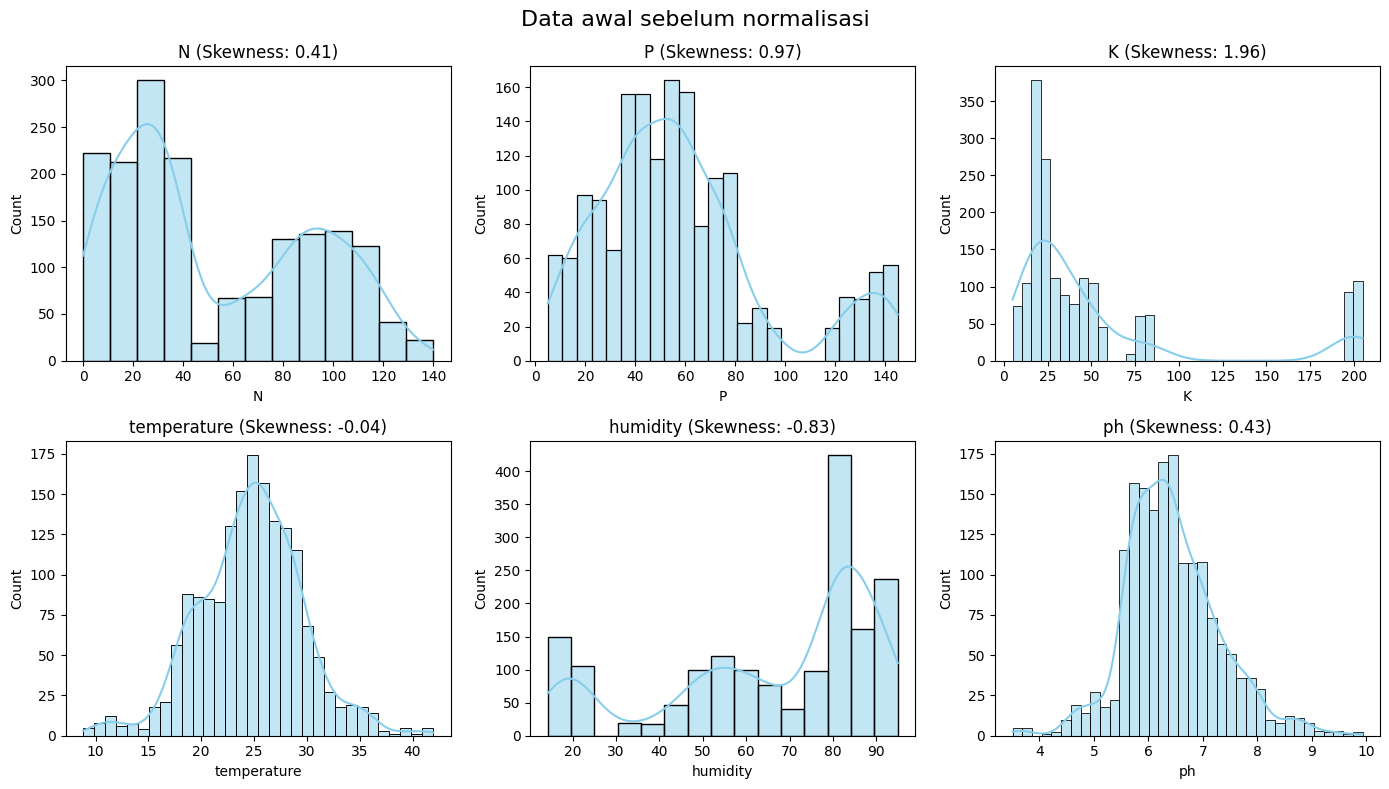

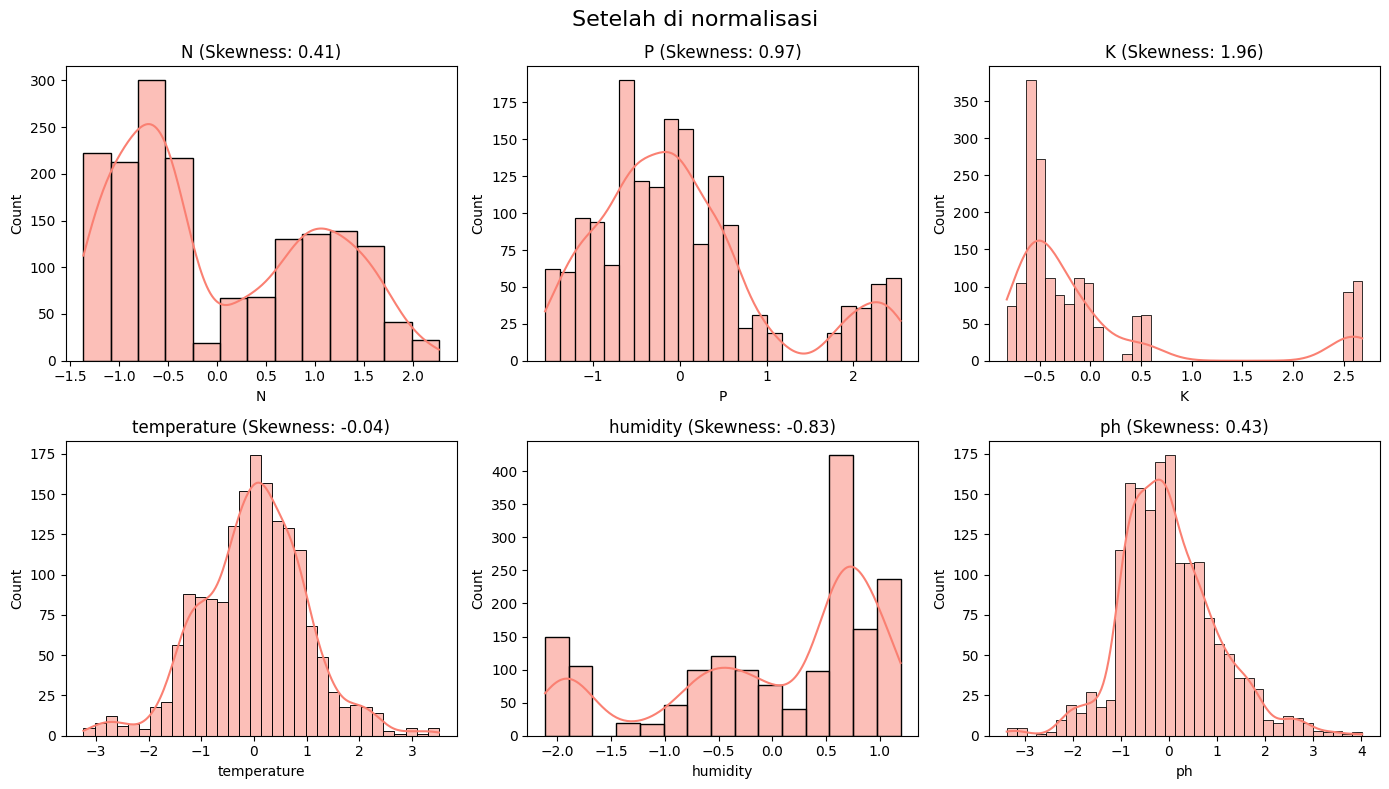

In [71]:
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph']
X = df[["N", "P", "K", "temperature", "humidity", "ph"]]
y = df["label"]

# Step 2: Plot original distributions and skewness
plt.figure(figsize=(14, 8))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(X[col], kde=True, color="skyblue")
    skew_val = X[col].skew()
    plt.title(f"{col} (Skewness: {skew_val:.2f})")
plt.suptitle("Data awal sebelum normalisasi", fontsize=16)
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

plt.figure(figsize=(14, 8))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(X_scaled_df[col], kde=True, color="salmon")
    skew_val = X_scaled_df[col].skew()
    plt.title(f"{col} (Skewness: {skew_val:.2f})")
plt.suptitle("Setelah di normalisasi", fontsize=16)
plt.tight_layout()
plt.show()

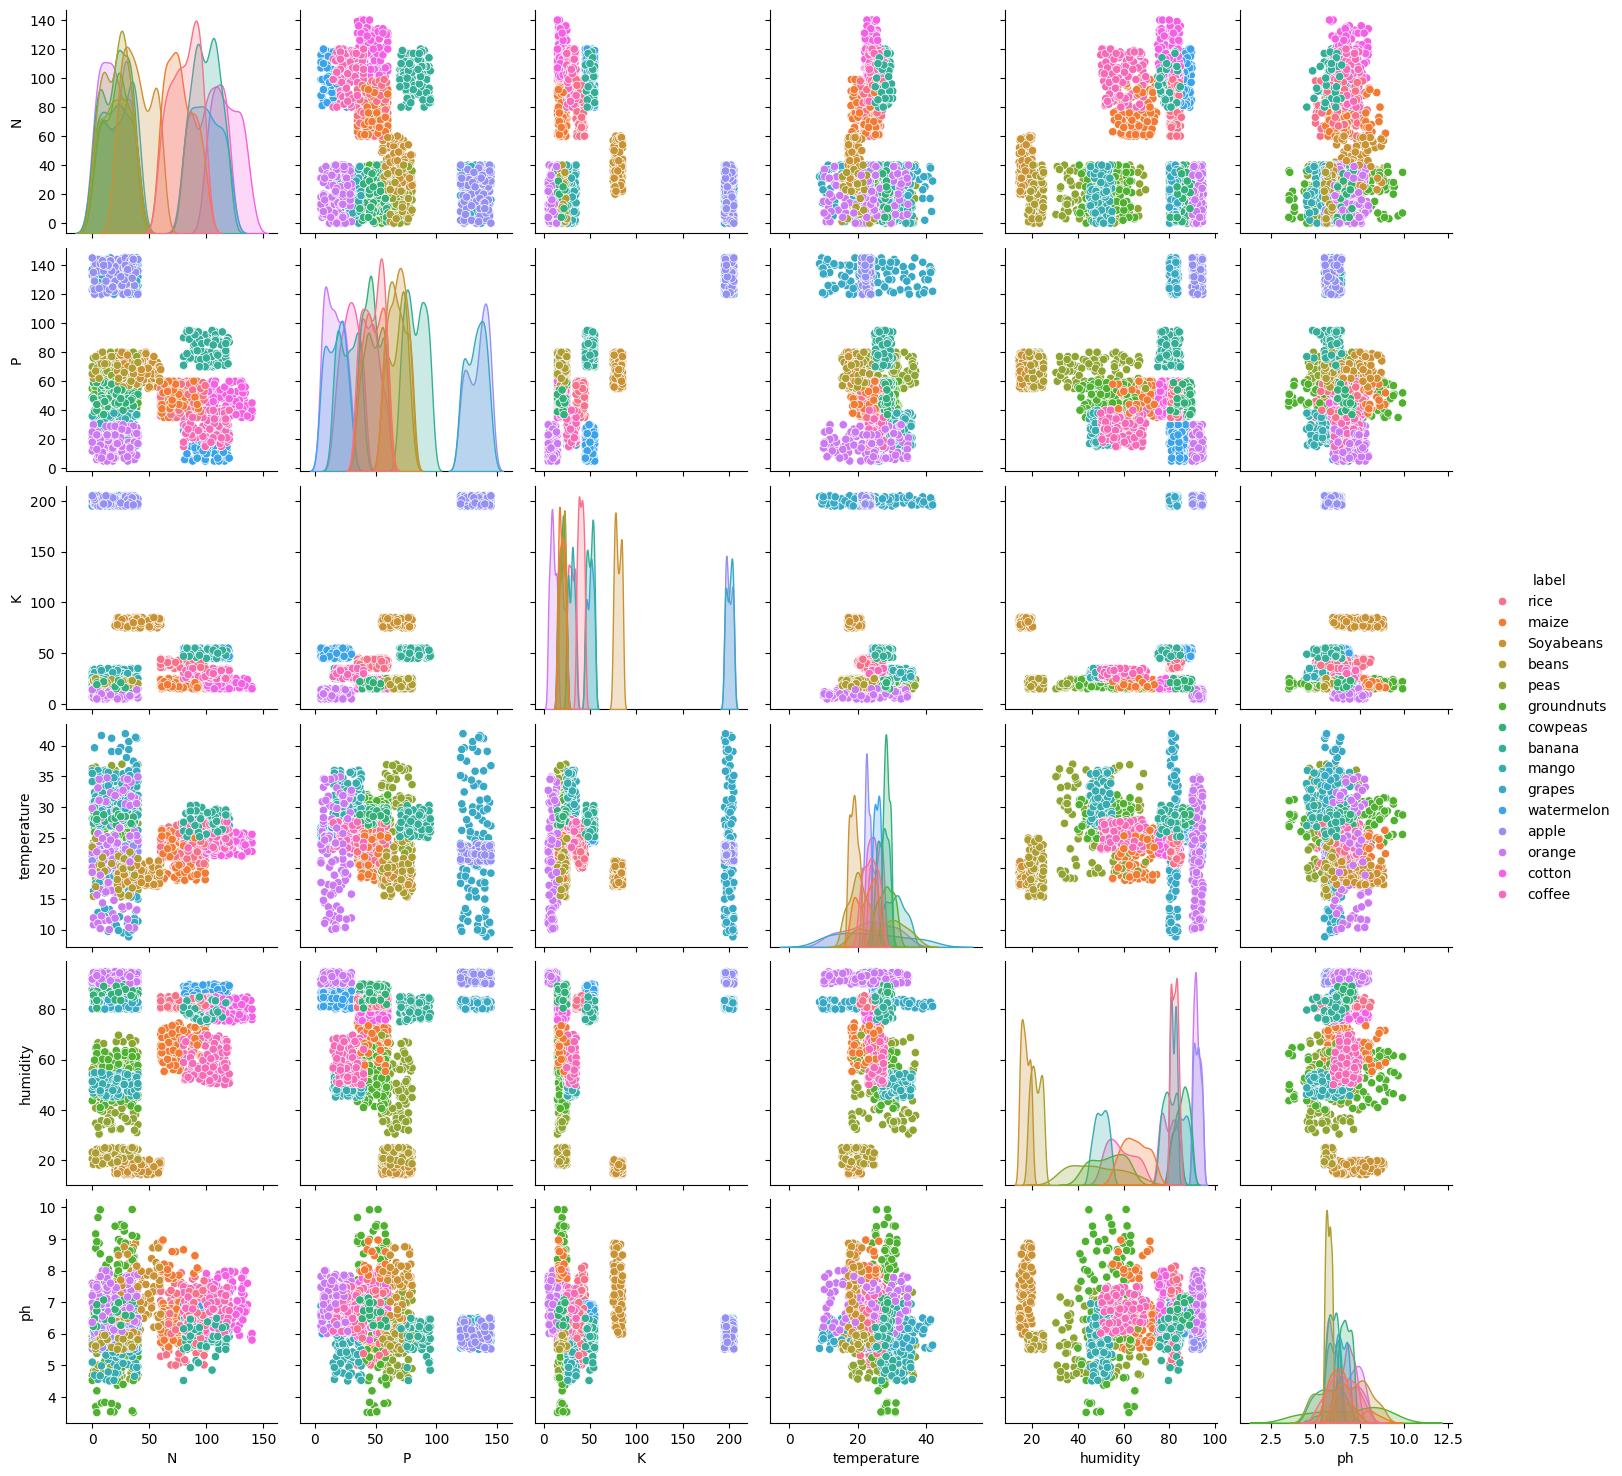

In [85]:
sns.pairplot(df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'label']], hue='label')
plt.suptitle('Relaltionship Feature Matrix', y=1.02)
plt.show()

## Membagi data menjadi 2/3 data training dan sisa nya akan masuk ke data testing

In [72]:
from sklearn.model_selection import train_test_split

df_scaled = X_scaled_df.copy()
df_scaled['label'] = df['label'].values  # preserve label

train_data = pd.DataFrame()
test_data = pd.DataFrame()

for label in df_scaled['label'].unique():
    subset = df_scaled[df_scaled['label'] == label]
    train, test = train_test_split(subset, test_size=0.2, random_state=42, stratify=None)
    train_data = pd.concat([train_data, train])
    test_data = pd.concat([test_data, test])

print('Data Training')
print(train_data['label'].value_counts())
print("----------------------------------")
print('Data Testing')
print(test_data['label'].value_counts())

Data Training
label
rice          111
Soyabeans     104
banana        104
beans         100
cowpeas        97
orange         97
maize          95
coffee         88
peas           80
groundnuts     80
mango          80
watermelon     80
grapes         80
apple          80
cotton         80
Name: count, dtype: int64
----------------------------------
Data Testing
label
rice          28
Soyabeans     26
banana        26
cowpeas       25
beans         25
orange        25
maize         24
coffee        22
peas          20
groundnuts    20
mango         20
watermelon    20
grapes        20
apple         20
cotton        20
Name: count, dtype: int64


Training data dengan membentuk 100 pohon

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Features and target
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph']
X_train = train_data[features]
y_train = train_data['label']
X_test = test_data[features]
y_test = test_data['label']

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

train_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)

# Predict
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

Training Accuracy: 1.0000
Testing Accuracy: 0.9883


In [74]:
print("Accuracy:", test_acc)
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.9882697947214076
Precision (macro): 0.9866666666666667
Recall (macro): 0.9866666666666667
F1 Score (macro): 0.9866666666666667


In [75]:
print("\nLaporan klasifikasi:")
print(classification_report(y_test, y_pred))


Laporan klasifikasi:
              precision    recall  f1-score   support

   Soyabeans       1.00      1.00      1.00        26
       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        26
       beans       1.00      1.00      1.00        25
      coffee       1.00      1.00      1.00        22
      cotton       1.00      1.00      1.00        20
     cowpeas       1.00      1.00      1.00        25
      grapes       1.00      1.00      1.00        20
  groundnuts       0.90      0.90      0.90        20
       maize       1.00      1.00      1.00        24
       mango       1.00      1.00      1.00        20
      orange       1.00      1.00      1.00        25
        peas       0.90      0.90      0.90        20
        rice       1.00      1.00      1.00        28
  watermelon       1.00      1.00      1.00        20

    accuracy                           0.99       341
   macro avg       0.99      0.99      0.99       341
weig

In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(clf, X_train, y_train, X_test, y_test):
    # Predictions
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    test_f1 = f1_score(y_test, y_test_pred, average='macro')

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Testing Accuracy:  {test_acc:.4f}")
    print(f"Training F1 Score: {train_f1:.4f}")
    print(f"Testing F1 Score:  {test_f1:.4f}")
    
    # Diagnostic logic
    delta = train_acc - test_acc
    print("\nDiagnosis:")
    if train_acc < 0.8 and test_acc < 0.8:
        print("UNDERFITTING")
    elif delta > 0.1:
        print("OVERFITTING")
    else:
        print("WELL-BALANCED")

    return {
        "train_accuracy": train_acc,
        "test_accuracy": test_acc,
        "train_f1": train_f1,
        "test_f1": test_f1,
        "diagnosis": "underfitting" if train_acc < 0.8 and test_acc < 0.8
                     else "overfitting" if delta > 0.1
                     else "balanced"
    }

# USAGE:
evaluate_model(clf, X_train, y_train, X_test, y_test)

Training Accuracy: 1.0000
Testing Accuracy:  0.9883
Training F1 Score: 1.0000
Testing F1 Score:  0.9867

Diagnosis:
WELL-BALANCED


{'train_accuracy': 1.0,
 'test_accuracy': 0.9882697947214076,
 'train_f1': 1.0,
 'test_f1': 0.9866666666666667,
 'diagnosis': 'balanced'}

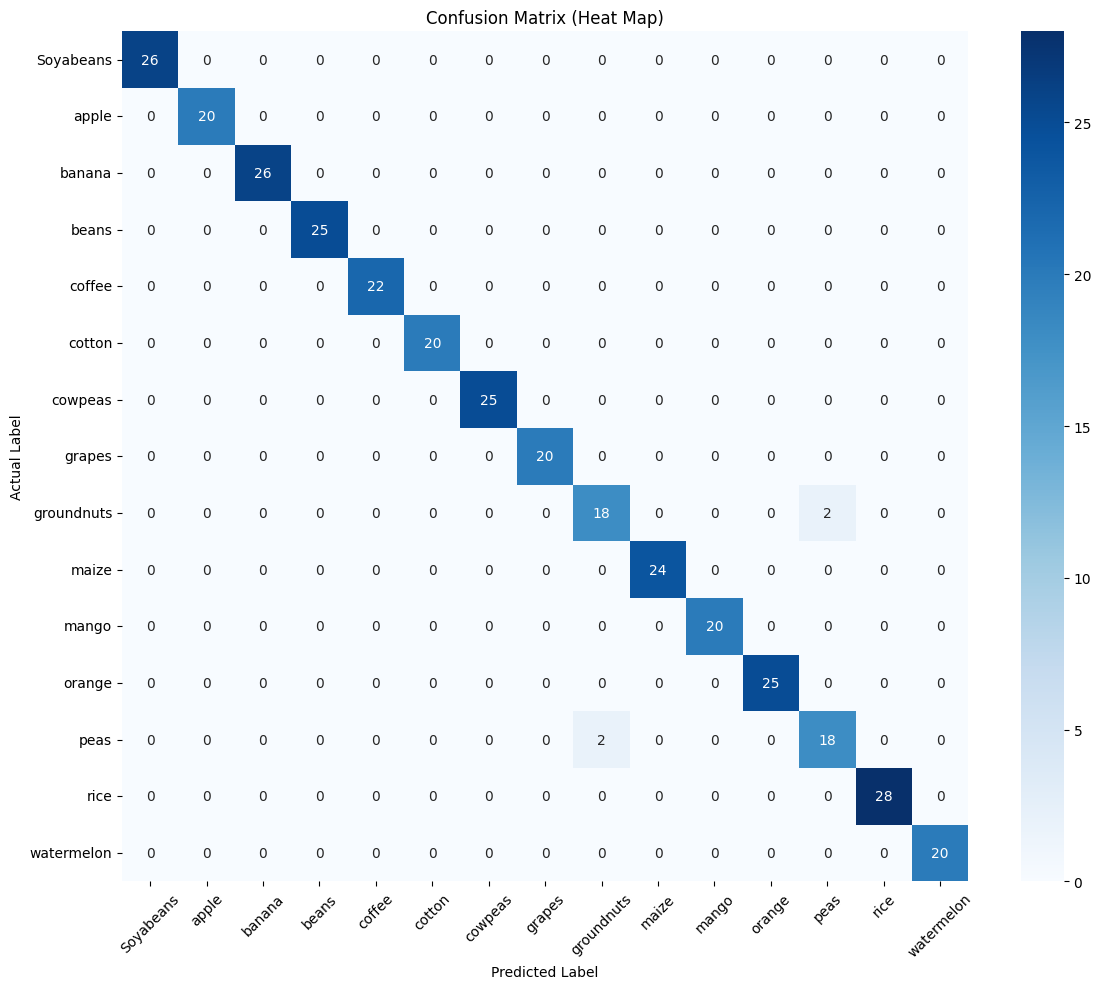

In [78]:


cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

# Turn into a DataFrame for readable format
cm_df = pd.DataFrame(cm, index=clf.classes_, columns=clf.classes_)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Heat Map)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [79]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

def cross_val_evaluation(model, X, y, cv=5):
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision_macro': make_scorer(precision_score, average='macro'),
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_macro': make_scorer(f1_score, average='macro')
    }

    results = cross_validate(
        model, X, y, cv=cv, scoring=scoring,
        return_train_score=True, n_jobs=-1
    )

    print("Cross-Validation Results (mean ± std):")
    for metric in scoring.keys():
        train_score = results[f'train_{metric}']
        test_score = results[f'test_{metric}']
        print(f"{metric.capitalize():<16} "
              f"Train: {train_score.mean():.4f} ± {train_score.std():.4f} | "
              f"Validation: {test_score.mean():.4f} ± {test_score.std():.4f}")

    return results
results = cross_val_evaluation(clf, X_train, y_train, cv=5)


Cross-Validation Results (mean ± std):
Accuracy         Train: 1.0000 ± 0.0000 | Validation: 0.9904 ± 0.0044
Precision_macro  Train: 1.0000 ± 0.0000 | Validation: 0.9904 ± 0.0039
Recall_macro     Train: 1.0000 ± 0.0000 | Validation: 0.9895 ± 0.0050
F1_macro         Train: 1.0000 ± 0.0000 | Validation: 0.9893 ± 0.0051


# Test new data

In [83]:
# Suppose this is your new incoming data
new_data = pd.DataFrame([{
    "N": 44.5,
    "P": 74.7,
    "K": 39.3,
    "temperature": 35.5,
    "humidity": 45.4,
    "ph": 6.6,
}])

X_new = new_data[["N", "P", "K", "temperature", "humidity", "ph"]]
y_true = new_data["label"]
# Scale using the same scaler used in training
X_new_scaled = pd.DataFrame(scaler.transform(X_new), columns=X_new.columns)

# Predict class and probabilities
y_pred = clf.predict(X_new_scaled)
y_proba = clf.predict_proba(X_new_scaled)[0]

print("🔮 Predicted label:", y_pred[0])

top3_indices = np.argsort(y_proba)[::-1][:3]  
top3_labels = clf.classes_[top3_indices]
top3_probs = y_proba[top3_indices]

# Display results
print("🔮 Top 3 predicted classes with probabilities:")
for label, prob in zip(top3_labels, top3_probs):
    print(f"{label:10s}: {prob:.2%}")

🔮 Predicted label: peas
🎯 True label: rice
🔮 Top 3 predicted classes with probabilities:
peas      : 49.00%
mango     : 31.00%
rice      : 7.00%

📊 Basic Evaluation (for 1 sample — interpret with caution):
Accuracy: 0.0
Precision: 0.0


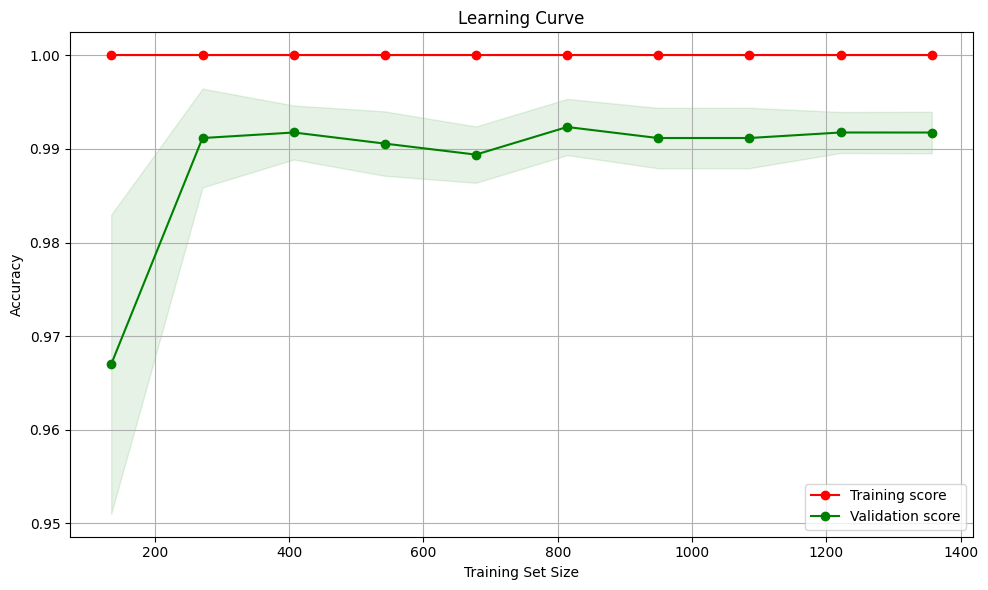

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, shuffle=True, random_state=42
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    val_scores_mean   = np.mean(val_scores, axis=1)
    val_scores_std    = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation score")

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(scoring.capitalize())
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_learning_curve(clf, X_scaled_df, df['label'], cv=5, scoring='accuracy')

## Understanding Precision, Recall, and F1-Score

Let's break down the use and interpretation of precision, recall, and the F1-score in the context of your classification model.

### Understanding the Basics with a Confusion Matrix

Imagine your random forest model is trying to predict whether a plant is 'rice' or 'not rice'. We can summarize the model's performance for the 'rice' class using a confusion matrix:

|                    | Predicted: Rice | Predicted: Not Rice |
| :----------------- | :-------------- | :------------------ |
| **Actual: Rice** | True Positive (TP) | False Negative (FN) |
| **Actual: Not Rice** | False Positive (FP) | True Negative (TN)  |

* **True Positive (TP):** The model correctly predicted 'rice', and it actually was 'rice'.
* **False Positive (FP):** The model incorrectly predicted 'rice', but it was actually 'not rice'. (Also known as a Type I error).
* **False Negative (FN):** The model incorrectly predicted 'not rice', but it was actually 'rice'. (Also known as a Type II error).
* **True Negative (TN):** The model correctly predicted 'not rice', and it actually was 'not rice'.

### 1. Precision: "Of all the plants the model said were rice, how many actually were?"

* **Formula:** $\text{Precision} = \frac{TP}{TP + FP}$
* **Usefulness:** Precision is useful when you want to minimize **false positives**. In other words, when you want to be very sure that if the model predicts a certain class, it's highly likely to be correct.
* **Interpretation:**
    * A **high precision** (closer to 1.0) means that when the model predicts a plant is 'rice', it is very often correct. There aren't many instances where it incorrectly labels a 'not rice' plant as 'rice'.
    * A **low precision** (closer to 0.0) means that when the model predicts a plant is 'rice', it is often wrong. Many 'not rice' plants are being incorrectly classified as 'rice'.

**Example Interpretation from Data:**

If your model has a precision of 0.85 for the 'rice' label, it means that out of every 100 plants your model predicted as 'rice', 85 of them were actually rice, and 15 were something else (false alarms).

### 2. Recall (Sensitivity or True Positive Rate): "Of all the plants that were actually rice, how many did the model correctly identify?"

* **Formula:** $\text{Recall} = \frac{TP}{TP + FN}$
* **Usefulness:** Recall is useful when you want to minimize **false negatives**. In other words, when it's important to identify as many actual positive instances as possible, even if it means having some false positives.
* **Interpretation:**
    * A **high recall** (closer to 1.0) means that the model is good at finding most of the actual 'rice' plants. It doesn't miss many of them.
    * A **low recall** (closer to 0.0) means that the model misses many of the actual 'rice' plants, incorrectly classifying them as 'not rice'.

**Example Interpretation from Data:**

If your model has a recall of 0.92 for the 'rice' label, it means that out of every 100 plants that were actually rice, your model correctly identified 92 of them. It missed 8 actual rice plants.

### 3. F1-Score: Finding the Balance Between Precision and Recall

* **Formula:** $\text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$
* **Usefulness:** The F1-score is the harmonic mean of precision and recall. It provides a single metric that balances both concerns. It's particularly useful when you have an imbalanced dataset (where one class has significantly more instances than others) or when both false positives and false negatives are important to consider.
* **Interpretation:**
    * A **high F1-score** (closer to 1.0) indicates a good balance between precision and recall. The model is performing well in both correctly identifying positive instances and minimizing false alarms and misses.
    * A **low F1-score** (closer to 0.0) suggests that the model has a poor balance between precision and recall. It might have high precision but low recall (or vice versa), indicating a problem with the classification performance.

**Example Interpretation from Data:**

If your model has an F1-score of 0.88 for the 'rice' label, it suggests a relatively good balance between its ability to correctly predict rice and its ability to find all the actual rice plants.

### How to Interpret from Your Overall Output:

When you calculated the `accuracy`, `precision`, `recall`, and `f1_score` with `average='weighted'`, these metrics are calculated for each class (rice, banana, soybean, etc.) and then averaged, weighted by the number of true instances for each class. This gives you an overall sense of how well your model performs across all the different crop labels, taking into account any class imbalance in your test set.

* **Accuracy:** Gives you the overall percentage of correctly classified instances. While easy to understand, it can be misleading on imbalanced datasets.
* **Weighted Precision:** Tells you, on average (weighted by the prevalence of each class), how often the model's positive predictions were correct.
* **Weighted Recall:** Tells you, on average (weighted by the prevalence of each class), what proportion of actual positive instances the model correctly identified.
* **Weighted F1-score:** Provides a single, balanced measure of the model's performance across all classes, considering both precision and recall and accounting for class imbalance.

By looking at these metrics together, you can get a comprehensive understanding of your model's strengths and weaknesses in classifying different crop types. For example, if you see a high precision but a lower recall for a specific crop, it means the model is very confident when it predicts that crop, but it might be missing some actual instances of that crop. The F1-score helps you see the overall trade-off.